# Inline Holography with gPIE

This notebook demonstrates how to perform Expectation Propagation (EP)-based inference for inline holography using the gPIE framework.
We reconstruct a complex-valued object wave from amplitude-only holographic measurements.

### 1. Imports and Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from gpie import model, SupportPrior, fft2, AmplitudeMeasurement, mse
from gpie.core.linalg_utils import circular_aperture

# load sample image from sk-image library
import os
import sys
EXAMPLES_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, EXAMPLES_DIR)

from io_utils import load_sample_image

### 2. Graph Construction

We model inline holography as a probabilistic inverse problem using Bayes' theorem.

The observation model assumes that the measured intensity is the magnitude of the Fourier transform of a superimposed object and reference wave, plus Gaussian noise:

$$
\mathbf{y} = \left| \mathcal{F}(\mathbf{x} + \mathbf{r}) \right| + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

We aim to infer the unknown object wave $ \mathbf{x} $, given the measurement $ \mathbf{y} $ and known reference $ \mathbf{r} $.  
This leads to the posterior:

$$
p(\mathbf{x} \mid \mathbf{y}) \propto p(\mathbf{y} \mid \mathbf{x}) \cdot \mathcal{P}_{\text{support}}(\mathbf{x})
$$

- $ p(\mathbf{y} \mid \mathbf{x}) $: likelihood induced by the nonlinear magnitude measurement
- $ \mathcal{P}_{\text{support}}(\mathbf{x}) $: prior enforcing known support on $ \mathbf{x} $

Specifically, the prior enforces:

$$
\text{supp}(\mathbf{x}) \subseteq \Omega_{\text{obj}}
$$



In [2]:
@model
def holography(support, ref_wave, var):
    obj = ~SupportPrior(support=support, label="obj", dtype=np.complex64)
    AmplitudeMeasurement(var=var) << fft2(ref_wave + obj)

We define the computational factor graph for inline holography inference using the gPIE DSL.

The key line in this graph definition is:

```python
AmplitudeMeasurement(var=var, damping=0.05) @ (fft2(ref_wave + obj))
```

This represents a **factor node** connected to the **composition of other factors**, forming:

$$
\text{AmplitudeMeasurement} \circ \mathcal{F} \circ (\mathbf{r} + \mathbf{x})
$$

Here's how to interpret each component:

- `obj = ~SupportPrior(...)`  
    ↪️ Declares a latent object wave $ \mathbf{x} \sim \mathcal{P}_{\text{support}} $ with known support  
    ↪️ The `~` operator means “sampled from this prior”

- `ref_wave + obj`  
    ↪️ Reference wave $ \mathbf{r} $ is treated as a constant array  
    ↪️ This expression represents $ \mathbf{r} + \mathbf{x} $, the wave before propagation

- `fft2(...)`  
    ↪️ Applies a centered 2D Fourier transform $ \mathcal{F} $

- `AmplitudeMeasurement(...)`  
    ↪️ Models the noisy magnitude observation  
    ↪️ It receives the Fourier-domain wave and applies  
      $ y = |\cdot| + \varepsilon $, with additive Gaussian noise of variance `var`  
    ↪️ damping (e.g 0.05) is used to stabilize EP iteration. Note that damping = 0 corresponds to no dumping.

- `<<` operator  
    ↪️ **Connects factors in sequence**, constructing a composite mapping  

This concise DSL allows gPIE to define complex graphical models with readable Python code that mirrors the probabilistic structure of the problem.

### 3. Data Preparation

In [3]:
H, W = 256, 256
noise_var = 1e-4

# Load reference and object images
ref_img = load_sample_image("moon", shape=(H, W))      # grayscale [0,1]
obj_img = load_sample_image("camera", shape=(H, W))

# Generate complex reference and object waves
support_ref = circular_aperture((H, W), radius=0.2, center=(-0.2, -0.2))
support_obj = circular_aperture((H, W), radius=0.15, center=(0.2, 0.2))

ref_wave = ref_img.astype(np.complex64) * support_ref
true_obj = obj_img.astype(np.complex64) * support_obj

### 4. Build Graph and Inject Sample

In [4]:
graph = holography(var=noise_var, ref_wave=ref_wave, support=support_obj)
graph.set_init_rng(np.random.default_rng(11))
graph.get_wave("obj").set_sample(true_obj)

# Generate noisy observation
graph.generate_sample(rng=np.random.default_rng(9), update_observed=True)

- `set_init_rng(...)`  
  ➤ Sets the random number generator used for initializing internal EP messages.  
  This ensures reproducibility of the EP inference process.

- `get_wave("obj")`  
  ➤ Retrieves the latent variable node labeled `"obj"`, which was defined via `SupportPrior(...)`.  
  Labels are automatically assigned from the prior factor unless overridden.

- `set_sample(true_obj)`  
  ➤ Manually injects the ground truth complex-valued object wave into the `"obj"` node.  
  This is useful when generating synthetic measurements from a known target.  
  If not set explicitly, the sample would be drawn randomly from the prior during `generate_sample()`.

- `generate_sample(...)`  
  ➤ Simulates observed data from the model by sampling from the forward path:  
  $ y = |\mathcal{F}(x + r)| + \varepsilon $  
  The `update_observed=True` flag ensures that the sampled output at `AmplitudeMeasurement` node is used as the observed dataset.

### 5. Run Inference and Track Error

In [5]:
n_iter = 50
pse_list = []

def monitor(graph, t):
    if t % 5 == 0 or t == n_iter - 1:
        est = graph.get_wave("obj").compute_belief().data
        err = mse(est, true_obj)
        pse_list.append(err)
        print(f"[t={t}] PSE = {err:.2e}")

graph.run(n_iter=n_iter, callback=monitor)

[t=0] PSE = 3.83e-02
[t=5] PSE = 1.72e-04
[t=10] PSE = 4.51e-05
[t=15] PSE = 4.33e-05
[t=20] PSE = 4.33e-05
[t=25] PSE = 4.34e-05
[t=30] PSE = 4.35e-05
[t=35] PSE = 4.35e-05
[t=40] PSE = 4.35e-05
[t=45] PSE = 4.36e-05
[t=49] PSE = 4.36e-05


### 6. Visualize Results

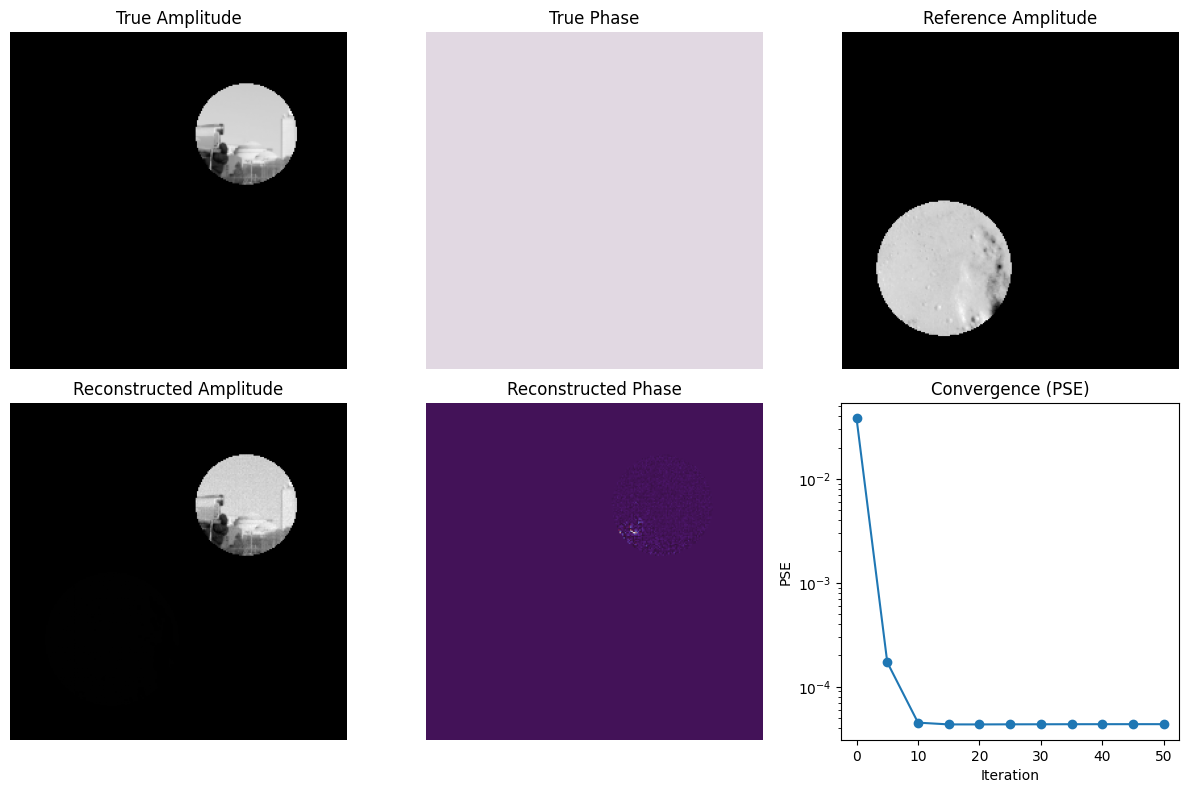

In [6]:
est = graph.get_wave("obj").compute_belief().data[0]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
vmax = np.abs(true_obj).max()

axes[0,0].imshow(np.abs(true_obj), cmap='gray')
axes[0,0].set_title("True Amplitude")
axes[0,1].imshow(np.angle(true_obj) * (np.abs(true_obj) > 1e-5), cmap='twilight')
axes[0,1].set_title("True Phase")
axes[0,2].imshow(np.abs(ref_wave), cmap='gray')
axes[0,2].set_title("Reference Amplitude")

axes[1,0].imshow(np.abs(est), cmap='gray')
axes[1,0].set_title("Reconstructed Amplitude")
axes[1,1].imshow(np.angle(est) * (np.abs(true_obj) > 1e-5), cmap='twilight')
axes[1,1].set_title("Reconstructed Phase")
axes[1,2].plot(np.arange(0, len(pse_list)) * 5, pse_list, marker='o')
axes[1,2].set_title("Convergence (PSE)")
axes[1,2].set_yscale('log')
axes[1,2].set_xlabel("Iteration")
axes[1,2].set_ylabel("PSE")

for ax in axes.flat:
    ax.axis("off") if ax != axes[1,2] else None
plt.tight_layout()
plt.show()